In [ ]:
import os
import shutil
import os
 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'
print(src_folder)
print(dst_folder)

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)

In [ ]:
exp_name = 'codegen2_1B_humaneval_py'
# exp_name = 'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java'
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
!python convert_to_pre_eval.py --source_file $sf --target_dir $td


In [ ]:
# import subprocess
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"


# # subprocess.run(eval_cmd, shell=True)
print("### EVALUATION COMMAND ###")
print('#',eval_cmd)
print("### EVALUATION COMMAND ###")


In [ ]:
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:/tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:rw multipl-e-eval --dir /tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java --output-dir /tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java --recursive
### EVALUATION COMMAND ###

In [ ]:
exp_name = 'codegen2_1B_humaneval_py'
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
target_dir = f'{td}'
output_file = f'res/{exp_name}_results.json'
!python pass_k.py $target_dir --output $output_file

#### Visualize the results

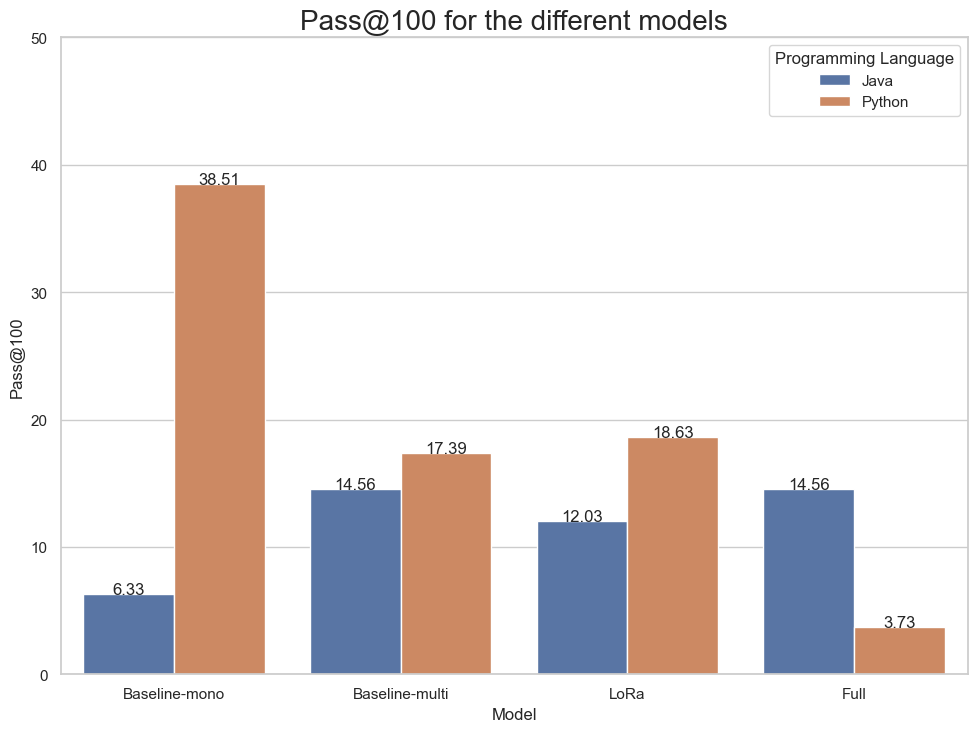

In [15]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


#get all the results files in the res folder
results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]

#load all the results files into a dictionary
results = {}
for f in results_files:
    with open(os.path.join('res', f)) as json_file:
        results[f] = json.load(json_file)
['Baseline', 'LoRa-V3-2000',
       'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py',
       'Full-V3-1000']
#Models Short Names
model_names_dict = {
    'codegen_350M_mono_humaneval_py': 'Baseline-mono',
    'codegen_350M_mono_humaneval_java': 'Baseline-mono',

    'codegen_350M_multi_humaneval_py': 'Baseline-multi',
    'codegen_350M_multi_humaneval_java': 'Baseline-multi',

    'codegen2_1B_humaneval_py': 'Baseline-multi-1B',
    'codegen2_1B_humaneval_java': 'Baseline-multi-1B',

    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_3000_humaneval_java': 'LoRa',
    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_3000_humaneval_py': 'LoRa',

    'codegne1B_finetuned_LoRa_the_stack_java_v5_checkpoint_800_humaneval_py': 'LoRa-1B',
    'codegne1B_finetuned_LoRa_the_stack_java_v5_checkpoint_800_humaneval_java': 'LoRa-1B',

    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py': 'Full',
    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java': 'Full'
}


#Merge all the results into a single dataframe
dict_df = {
    'model': [],
    'dataset': [],
    'pass@10': [],
    'pass@100': [],
    'num_problems': [],
    'min_completions': [],
    'max_completions': [],
    'programming_language': []
}

for model in results.keys():
    model_results = results[model]
    model_name = model.split('_results.json')[0]
    if model_name in model_names_dict.keys():
        model_name = model_names_dict[model_name]
    dataset_name = model_results['pass@10']['dataset']
    pass_10 = model_results['pass@10']['estimate']
    pass_100 = model_results['pass@100']['estimate']
    num_problems = model_results['pass@10']['num_problems']
    min_completions = model_results['pass@10']['min_completions']
    max_completions = model_results['pass@10']['max_completions']
    if 'humaneval_py' in dataset_name:
        programming_language = 'python'
    elif 'humaneval_java' in dataset_name:
        programming_language = 'java'
    else:
        programming_language = 'unknown'
    dict_df['model'].append(model_name)
    dict_df['dataset'].append(dataset_name)
    dict_df['pass@10'].append(pass_10)
    dict_df['pass@100'].append(pass_100)
    dict_df['num_problems'].append(num_problems)
    dict_df['min_completions'].append(min_completions)
    dict_df['max_completions'].append(max_completions)
    dict_df['programming_language'].append(programming_language)

df = pd.DataFrame(dict_df)

#Drop the dataset column
df = df.drop(columns=['dataset'])

#Drop the min_completions and max_completions columns
df = df.drop(columns=['min_completions', 'max_completions'])

#Drop the num_problems column
# df = df.drop(columns=['num_problems'])

#Drop the LoRa-V3-2000 model
df = df[df['model'] != 'LoRa-V3-2000']

#Drop the LoRa-V5-1000 model
df = df[df['model'] != 'LoRa-V5-1000']

#Multiply the pass@10 and pass@100 by 100
df['pass@10'] = df['pass@10'] * 100
df['pass@100'] = df['pass@100'] * 100

#Rename programming_language column to Programming Language, model to Model and pass@10 to Pass@10 and pass@100 to Pass@100
df = df.rename(columns={'programming_language': 'Programming Language'})
df = df.rename(columns={'model': 'Model'})
df = df.rename(columns={'pass@10': 'Pass@10'})
df = df.rename(columns={'pass@100': 'Pass@100'})

#Rename java to Java and python to Python
df['Programming Language'] = df['Programming Language'].replace({'java': 'Java', 'python': 'Python'})



#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Model", y="Pass@100", hue="Programming Language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 50
plt.ylim(0, 50)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#Add a title in bigger font
plt.title('Pass@100 for the different models', fontsize=20)
plt.show()



C:\Users\Edin\AppData\Local\Temp\ipykernel_15976\3301723631.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df.groupby(['Model']).mean().reset_index()


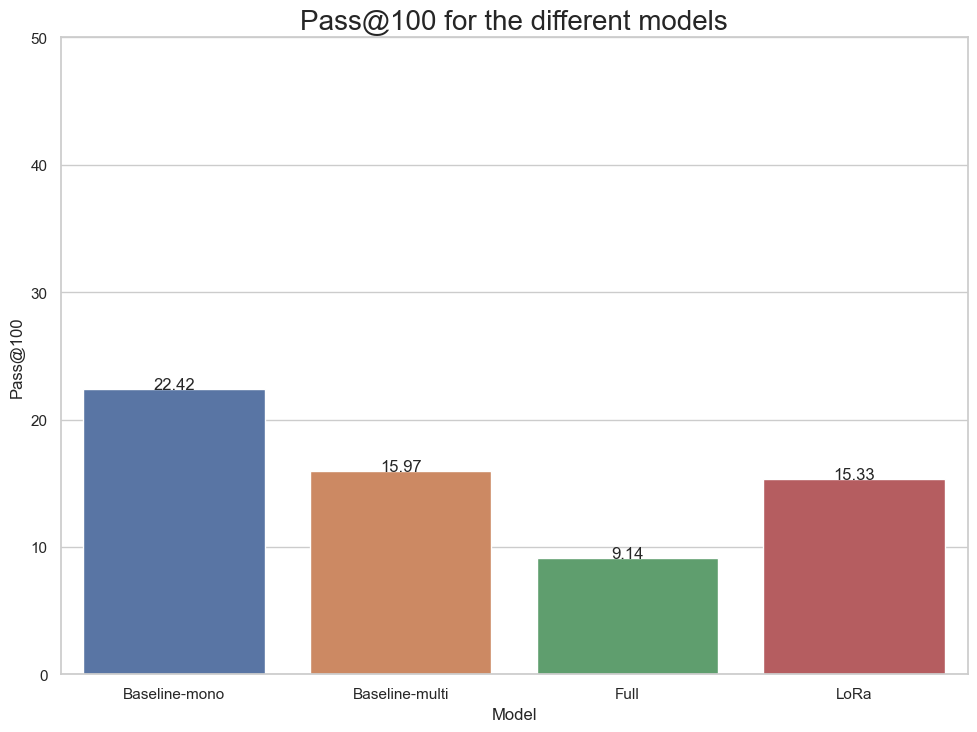

In [26]:
#Create new dataframe with only one row per model by averaging the pass@10 and pass@100 for the java and python datasets
df2 = df.groupby(['Model']).mean().reset_index()

#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Model", y="Pass@100", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 50
plt.ylim(0, 50)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#Add a title in bigger font
plt.title('Pass@100 for the different models', fontsize=20)
plt.show()

In [23]:
# Total number of tokens in the dataset for lora
num_tokens_per_input = 2048
batch_size = 4
num_steps = 3000
total_tokens = num_tokens_per_input * batch_size * num_steps
print(f'Total number of tokens in the dataset for lora: {total_tokens}')

# Total number of tokens in the dataset for Full
num_tokens_per_input = 512
batch_size = 16
num_steps = 1000
total_tokens_full = num_tokens_per_input * batch_size * num_steps
print(f'Total number of tokens in the dataset for Full: {total_tokens_full}')
print(f'Ratio of tokens between lora and full: {total_tokens / total_tokens_full}')

Total number of tokens in the dataset for lora: 24576000
Total number of tokens in the dataset for Full: 8192000
Ratio of tokens between lora and full: 3.0


In [ ]:
# Figure 1 show the Pass@100 for the different models. Baseline-mono and Baseline-multi are the two 350M models without any finetuning. The LoRa and Full are the results of the finetuned models of the Baseline-mono.
# Baseline-mono was prereained on BigPython dataset. The data consists of 71.7B tokens of Python programming language.
# Baseline-multi was pretrained on BigQuery dataset. The data consists of 119.2B tokens and includes C, C++, Go, Java, JavaScript, and Python.
# The LoRa model was finetuned on the Stack dataset. The finetuning was done for 24.5M tokens of Java programming language.
# The Full model was finetuned on the Stack dataset. The finetuning was done for 8.2M tokens of Java programming language.
# We were able to finetune the LoRa model for 3K steps and the Full model for 1K steps, using the same compute resources for both models. That is because the LoRa paramters are only 10% of the Full model parameters.
# Of all the models, the Baseline-mono has the best pass@100 score for python at 38.51% , but the worst score for java at 6.33%.
# The Baseline-multi and the Full models have the best pass@100 score for java at 14.56% for both models. However, the Full model has the worst score for python at 3.73% followed by the Baseline-multi at 17.39%.
# The LoRa model has the second best pass@100 score for python at 19.63.21% and the third best score for java at 12.03%. 
# The important takeaways from theses results are:
# 1. For Smaller models , training on a single progrmming lnaguage is significantly better than training on multiple programming languages as shown by the Baseline-mono and Baseline-multi models.
# 2. Using Paramter Efficent Fine tuning (PEFT) enables us to finetune a smaller number of paramters on a larger number of tokens using the same compute resources and still get comparable results to using Full Paramter Fine tuning.
# 3. The Full Model has the same pass@100 score as basline-multi for java, even tough it have seen far less tokens. This shows that smaller models are not sutiable for pretraining on multiple programming languages.
# 4. The LoRa Model socre on Python is 5 times better than the Full model, Proving that PEFT is a better approach to avid catastrophic forgetting.
# 5. All the scores on Java are low compared to Python. This may indicate a problem with the evaluation as the problem prompts in Java are significanlty longer and the stopping criteria is not well defined for Java.
# 6. The Fact that the LoRa model has good scores on both Python and Java could be explored further on the translation task of HumanEval.

In [18]:
#Result Analysis
print('### Result Analysis ###')
#Model with the highest Pass@100 for Java
model_with_highest_pass_100_java = df[(df['Programming Language'] == 'Java') & (df['Pass@100'] == df[df['Programming Language'] == 'Java']['Pass@100'].max())]['Model'].values[0]
#Model with the highest Pass@100 for Python
model_with_highest_pass_100_python = df[(df['Programming Language'] == 'Python') & (df['Pass@100'] == df[df['Programming Language'] == 'Python']['Pass@100'].max())]['Model'].values[0]
#Highest Pass@100 for Java
highest_pass_100_java = df[df['Programming Language'] == 'Java']['Pass@100'].max()
#Highest Pass@100 for Python
highest_pass_100_python = df[df['Programming Language'] == 'Python']['Pass@100'].max()

#LoRa Pass@100 for Java
lora_pass_100_java = df[(df['Model'] == 'LoRa') & (df['Programming Language'] == 'Java')]['Pass@100'].values[0]
#LoRa Pass@100 for Python
lora_pass_100_python = df[(df['Model'] == 'LoRa') & (df['Programming Language'] == 'Python')]['Pass@100'].values[0]

#Full Pass@100 for Java
full_pass_100_java = df[(df['Model'] == 'Full') & (df['Programming Language'] == 'Java')]['Pass@100'].values[0]
#Full Pass@100 for Python
full_pass_100_python = df[(df['Model'] == 'Full') & (df['Programming Language'] == 'Python')]['Pass@100'].values[0]

#Precntage of improvement of LoRa over the Baseline for Java
lora_improvement_over_baseline_java = (lora_pass_100_java - highest_pass_100_java) / highest_pass_100_java * 100
#Precntage of improvement of LoRa over the Baseline for Python
lora_improvement_over_baseline_python = (lora_pass_100_python - highest_pass_100_python) / highest_pass_100_python * 100

#Precntage of improvement of Full over the Baseline for Java
full_improvement_over_baseline_java = (full_pass_100_java - highest_pass_100_java) / highest_pass_100_java * 100
#Precntage of improvement of Full over the Baseline for Python
full_improvement_over_baseline_python = (full_pass_100_python - highest_pass_100_python) / highest_pass_100_python * 100


print(f'Model with the highest Pass@100 for Java: {model_with_highest_pass_100_java} at {highest_pass_100_java}')
print(f'Model with the highest Pass@100 for Python: {model_with_highest_pass_100_python} at {highest_pass_100_python}')
print(f'LoRa Pass@100 for Java: {lora_pass_100_java}')
print(f'LoRa Pass@100 for Python: {lora_pass_100_python}')
print(f'Full Pass@100 for Java: {full_pass_100_java}')
print(f'Full Pass@100 for Python: {full_pass_100_python}')
print(f'Precntage of improvement of LoRa over the Baseline for Java: {lora_improvement_over_baseline_java}')
print(f'Precntage of improvement of LoRa over the Baseline for Python: {lora_improvement_over_baseline_python}')
print(f'Precntage of improvement of Full over the Baseline for Java: {full_improvement_over_baseline_java}')
print(f'Precntage of improvement of Full over the Baseline for Python: {full_improvement_over_baseline_python}')


### Result Analysis ###
Model with the highest Pass@100 for Java: Baseline-multi at 14.556962025316455
Model with the highest Pass@100 for Python: Baseline-mono at 38.50931677018634
LoRa Pass@100 for Java: 12.025316455696203
LoRa Pass@100 for Python: 18.633540372670808
Full Pass@100 for Java: 14.556962025316455
Full Pass@100 for Python: 3.7267080745341614
Precntage of improvement of LoRa over the Baseline for Java: -17.391304347826082
Precntage of improvement of LoRa over the Baseline for Python: -51.61290322580645
Precntage of improvement of Full over the Baseline for Java: 0.0
Precntage of improvement of Full over the Baseline for Python: -90.3225806451613


### ALL FLOW

In [ ]:
import os
import shutil
import subprocess

 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)


#Loop over all the files in the src folder and get the experiment names to run
for file_name in os.listdir(src_folder):
    exp_name = file_name.split('.jsonl')[0]
    #Print the experiment name
    print(f'Now running experiment: {exp_name}')

    #Convert the jsonl file to the pre-evaluation format
    sf = f'src/{exp_name}.jsonl'
    td = f'tgt/{exp_name.replace("-", "")}'
    print(f'Converting {sf} to {td}')
    !python convert_to_pre_eval.py --source_file $sf --target_dir $td
    print('Done!')

    #Run the evaluation
    print(f'Running evaluation on {td}')
    eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"
    # subprocess.run(eval_cmd, shell=True)
    print("### EVALUATION COMMAND ###")
    print('#',eval_cmd)
    print("### EVALUATION COMMAND ###")
    # print('Done!')

    # Run the pass@k
    print(f'Running pass@k on {td}')
    target_dir = f'{td}'
    output_file = f'res/{exp_name}_results.json'
    !python pass_k.py $target_dir --output $output_file
    print('Done!')

    